This notebook performs analysis on how model checkpoints learn to predict a variable across its percentile 


First, we need to look at the .nc files in the directory `/projectnb/eb-general/shared_data/data/processed/FourCastNet_sfno/ERA5/training_data` and look at its structure.


 
- `var`: variable from ERA5 dataset to analyze
- `percentiles`: array of percentiles to analyze e.g. [90, 91, ..., 100]
- `grid_cell_latlon`: specific grid cell latitude and longitude to analyze percentiles

1. For the global ERA5 truth data of the variable `var`, compute the specified percentiles across the entire training period (1979-2015)
- the percentiles are defined as where the truth falls in or above the given percentile
- specifically we are computing which values of the variable `var` define the edges of each percentile bin

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io.img_tiles import Stamen

from datetime import datetime, timedelta
import os
import json
from typing import List
import sys
sys.path.append('/projectnb/eb-general/wade/sfno/Example_Code/')
from utils import *
sys.path.append(".")  # Add current directory to Python path

In [2]:
dir='/projectnb/eb-general/shared_data/data/processed/FourCastNet_sfno/ERA5/training_data'
# open a file in the dir
file = xr.open_dataset(os.path.join(dir, 'e5_2t_196810.nc'))
file

<xarray.Dataset> Size: 3GB
Dimensions:    (time: 744, latitude: 721, longitude: 1440)
Coordinates:
  * latitude   (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float64 12kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
  * time       (time) datetime64[ns] 6kB 1968-10-01 ... 1968-10-31T23:00:00
Data variables:
    VAR_2T     (time, latitude, longitude) float32 3GB ...
    utc_date   (time) int32 3kB ...
Attributes:
    DATA_SOURCE:          ECMWF: https://cds.climate.copernicus.eu, Copernicu...
    NETCDF_CONVERSION:    CISL RDA: Conversion from ECMWF GRIB1 data to netCDF4.
    NETCDF_VERSION:       4.8.1
    CONVERSION_PLATFORM:  Linux r4i7n26 4.12.14-95.51-default #1 SMP Fri Apr ...
    CONVERSION_DATE:      Thu Aug 11 18:36:42 MDT 2022
    Conventions:          CF-1.6
    NETCDF_COMPRESSION:   NCO: Precision-preserving compression to netCDF4/HD...
    history:              Thu Aug 11 18:36:57 2022: ncks -4 --ppc default=7 e...
    NCO:                  netCDF Operators version 5.0.3 (Homepage = http://n...

In [2]:
def get_six_hourly_dir(var: str, years: List[int]) -> str:
    base_dir = '/projectnb/eb-general/shared_data/data/processed/FourCastNet_sfno/ERA5/'
    if years.issubset(set(range(1950, 1979)).union(set(range(2016, 2025)))): # same as using <= operator
        base_dir += 'outside_training/6_hourly/'
    elif years.issubset(set(range(1979, 2016))):
        base_dir += 'training_data/6_hourly/'
    if var == "VAR_2T":
        base_dir += '2t/'
    else:
        base_dir += var.lower() + '/'
    return base_dir


In [6]:
# Grid cells for analyzing percentiles
grid_cell_latlon = [
    # (lat, lon)
    (34, -116+360),  # southwestern US, SoCal 
    (51.5, -0.75+360), # Northern Europe, London.  
    # (27.0,  278.25),  # Southern Florida, Miami where Ian made landfall
]
var = "VAR_2T" # "MSL"
percentiles = np.arange(0,101)  # 0 to 100. 0th percentile -- minimum observed value. 100th percentile -- maximum observed value.
# add .1 increments to the percentiles between 0 and 1, and between 99 and 100
percentiles = np.unique(np.round(np.sort(np.concatenate([np.arange(0,1,0.1), percentiles, np.arange(99.1,100,0.1)])),decimals=1))
print(f"Percentiles to compute: {percentiles}")

Percentiles to compute: [  0.    0.1   0.2   0.3   0.4   0.5   0.6   0.7   0.8   0.9   1.    2.
   3.    4.    5.    6.    7.    8.    9.   10.   11.   12.   13.   14.
  15.   16.   17.   18.   19.   20.   21.   22.   23.   24.   25.   26.
  27.   28.   29.   30.   31.   32.   33.   34.   35.   36.   37.   38.
  39.   40.   41.   42.   43.   44.   45.   46.   47.   48.   49.   50.
  51.   52.   53.   54.   55.   56.   57.   58.   59.   60.   61.   62.
  63.   64.   65.   66.   67.   68.   69.   70.   71.   72.   73.   74.
  75.   76.   77.   78.   79.   80.   81.   82.   83.   84.   85.   86.
  87.   88.   89.   90.   91.   92.   93.   94.   95.   96.   97.   98.
  99.   99.1  99.2  99.3  99.4  99.5  99.6  99.7  99.8  99.9 100. ]


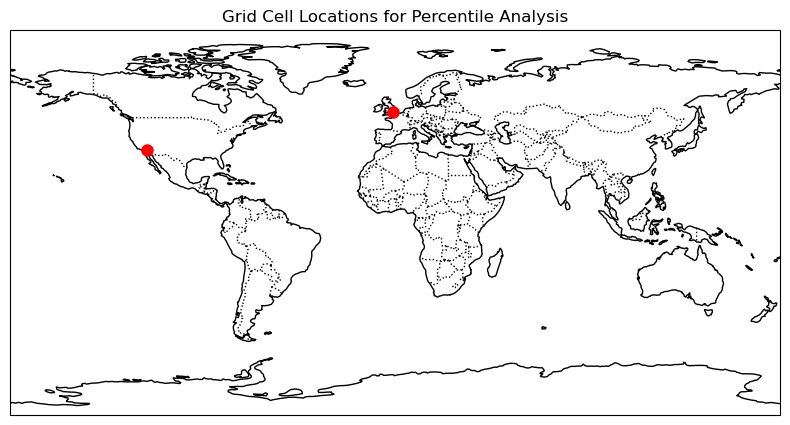

In [3]:
# plot the grid cell locations on a cartopy map

plt.figure(figsize=(10, 5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.set_global()
for lat, lon in grid_cell_latlon:
    ax.plot(lon if lon <= 180 else lon - 360, lat, marker='o', color='red', markersize=8,
            transform=ccrs.PlateCarree())
plt.title('Grid Cell Locations for Percentile Analysis')
plt.show()


In [ ]:
colors=['crimson','olivedrab']

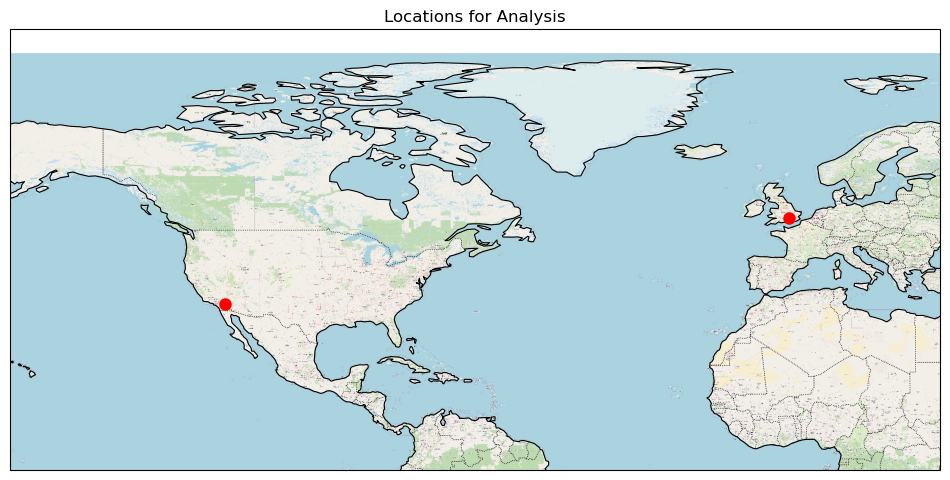

In [8]:
from cartopy.io.img_tiles import OSM

# Plot the grid cell locations on a cartopy map
plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.PlateCarree())

# Use OpenStreetMap (OSM) as a replacement for satellite imagery
osm_tiles = OSM()
ax.add_image(osm_tiles, 6)  # Adjust zoom level as needed

# Add coastlines and borders
ax.add_feature(cfeature.COASTLINE, linewidth=0.8)
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)

# Set extent to the northern hemisphere
ax.set_extent([-160, 30, 0, 90], crs=ccrs.PlateCarree())

# Plot grid cell locations
for lat, lon in grid_cell_latlon:
    ax.plot(lon if lon <= 180 else lon - 360, lat, marker='o', color='red', markersize=8,
            transform=ccrs.PlateCarree())

plt.title('Locations for Analysis')
plt.show()

Get data for one grid cell across all time steps, and order the data, define the percentiles, then save the values at each percentile to a new .nc file.



In [8]:
### FOR DATA WITHIN TRAINING PERIOD 1979-2015 ###
# six_hourly_dir = '/projectnb/eb-general/shared_data/data/processed/FourCastNet_sfno/ERA5/training_data/6_hourly/'
# if var == "VAR_2T":
#     six_hourly_dir += '2t/'
# else:
#     six_hourly_dir += var.lower() + '/'
six_hourly_dir = get_six_hourly_dir(var, set(range(1979, 2016)))
print(six_hourly_dir)
file_names = [path for path in os.listdir(six_hourly_dir) if not os.path.isdir(path) and path.endswith('.nc')]
file_names.sort()
print(min(file_names), max(file_names))

# # filter files to start with 201001
# file_names = [f for f in file_names if f >= 'e5_2t_201001.nc']
# print(min(file_names), max(file_names))

/projectnb/eb-general/shared_data/data/processed/FourCastNet_sfno/ERA5/training_data/6_hourly/2t/
e5_2t_197901.nc e5_2t_201512.nc


In [9]:
fp = os.path.join(six_hourly_dir, file_names[0])

ds = xr.open_dataset(fp,engine="netcdf4")
ds

<xarray.Dataset> Size: 515MB
Dimensions:    (time: 124, latitude: 721, longitude: 1440)
Coordinates:
  * latitude   (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float64 12kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
  * time       (time) datetime64[ns] 992B 1979-01-01 ... 1979-01-31T18:00:00
Data variables:
    MSL        (time, latitude, longitude) float32 515MB ...
    utc_date   (time) int32 496B ...
Attributes:
    DATA_SOURCE:          ECMWF: https://cds.climate.copernicus.eu, Copernicu...
    NETCDF_CONVERSION:    CISL RDA: Conversion from ECMWF GRIB1 data to netCDF4.
    NETCDF_VERSION:       4.6.1
    CONVERSION_PLATFORM:  Linux casper05 3.10.0-693.21.1.el7.x86_64 #1 SMP We...
    CONVERSION_DATE:      Mon May 13 19:16:31 MDT 2019
    Conventions:          CF-1.6
    NETCDF_COMPRESSION:   NCO: Precision-preserving compression to netCDF4/HD...
    history:              Mon May 13 19:17:03 2019: ncks -4 --ppc default=7 e...
    NCO:                  netCDF Operators version 4.7.4 (http://nco.sf.net)

In [10]:
# loop through files, select the data for that month at the grid cell, and add to a time series array
plt.figure()
for lat,lon in grid_cell_latlon:
    time_series = []
    for file_name in file_names:
        fp = os.path.join(six_hourly_dir, file_name)
        ds = xr.open_dataset(fp,engine="netcdf4")
        data_point = ds[var].sel(latitude=lat, longitude=lon)
        month_data = data_point.values
        time_series.extend(month_data)
        ds.close()
    time_series = np.array(time_series)
    # compute percentiles
    pct_values = np.percentile(time_series, percentiles) # first axis of the result corresponds to the percentiles
    # plot for this grid cell, what the percentile values are
    
    plt.plot(percentiles, pct_values-273.15, 'o', label=f'lat {lat}, lon {lon}')

    # save the percentile values to a json file
    pct_dict = {str(p): float(v) for p, v in zip(percentiles, pct_values)}
    with open(f'percentiles/percentile_values/percentiles_{var}_lat{lat}_lon{lon}.json', 'w') as f:
        json.dump(pct_dict, f)
    print(f'Saved percentiles for lat {lat}, lon {lon} to json.')

plt.xlabel('Percentile')
plt.ylabel(f'{var} Value')
plt.title(f'Percentiles of {var} at grid cells based on 1979-2015 record')
plt.legend()
plt.grid(alpha=0.3)
plt.savefig(f'percentiles/figs/percentiles_{var}.png', dpi=300)
plt.close()
    

Saved percentiles for lat 27.0, lon 278.25 to json.


### Related code below


In [4]:
six_hourly_dir

'/projectnb/eb-general/shared_data/data/processed/FourCastNet_sfno/ERA5/training_data/6_hourly/msl/'

In [ ]:
# CODE FOR EXTRACTING 6-HOURLY DATA FROM 1-HOURLY DATASETS
# years to trasnfer: years 1950-1978 (inclusive) and the period 2016-2024 (inclusive)
years_to_transfer = list(range(1950, 1979)) + list(range(2016, 2025)) # list(range(1979,2016))
six_hourly_dir = get_six_hourly_dir(var, set(years_to_transfer))
print(six_hourly_dir)

training_dir = '/projectnb/eb-general/shared_data/data/processed/FourCastNet_sfno/ERA5/training_data/'
file_names = [path for path in os.listdir(training_dir) if not os.path.isdir(path) and path.endswith('.nc')]
file_names.sort()
# # start from 200405 onwards
# file_names = [f for f in file_names if f >= 'e5_msl_200405.nc']
print(min(file_names), max(file_names))
print(file_names)

In [14]:
for ind, f in enumerate(file_names):
    fp = os.path.join('/projectnb/eb-general/shared_data/data/processed/FourCastNet_sfno/ERA5/training_data', f)
    ds = xr.open_dataset(fp,engine="netcdf4")

    # print(f)
    # print('t0', ds.isel(time=0).time.values, 't-1', ds.isel(time=-1).time.values, 'dt', np.diff(ds.time.values[:2])/np.timedelta64(1,'h'), ' hours')
    # print('datavars', list(ds.data_vars))
    # print('datadims', ds.dims)
    list(ds.data_vars).remove('utc_date')
    data_var_of_interest = list(ds.data_vars)[0]
    descrip = ds[data_var_of_interest].attrs
    # print(descrip)
    # print()

    # select only every 6 hourly timestamp, given that the data is stored in ds.time and the ds.time array has dtype='datetime64[ns]'
    hours = ds.time.dt.hour
    # time snapshots at 0000, 0600, 1200, 1800, UTC so where hours is 0, 6, 12, or 18
    mask = (hours == 0) | (hours == 6) | (hours == 12) | (hours == 18)
    # print(mask)
    six_hourly_times = ds.time.where(mask, drop=True)
    # print('six_hourly_times', six_hourly_times.values, 'dt', np.diff(six_hourly_times.values[:2])/np.timedelta64(1,'h'), ' hours')
    ds_6hourly = ds.sel(time=six_hourly_times)
    if ind % 100 == 0:
        print(ds_6hourly)
    
    # save to the six_hourly_dir
    ds_6hourly.to_netcdf(os.path.join(six_hourly_dir, f))
    

<xarray.Dataset> Size: 515MB
Dimensions:    (time: 124, latitude: 721, longitude: 1440)
Coordinates:
  * latitude   (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float64 12kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
  * time       (time) datetime64[ns] 992B 1950-01-01 ... 1950-01-31T18:00:00
Data variables:
    VAR_2T     (time, latitude, longitude) float32 515MB ...
    utc_date   (time) int32 496B ...
Attributes:
    DATA_SOURCE:          ECMWF: https://cds.climate.copernicus.eu, Copernicu...
    NETCDF_CONVERSION:    CISL RDA: Conversion from ECMWF GRIB1 data to netCDF4.
    NETCDF_VERSION:       4.8.1
    CONVERSION_PLATFORM:  Linux r2i4n12 4.12.14-95.51-default #1 SMP Fri Apr ...
    CONVERSION_DATE:      Sat Apr 22 14:57:42 MDT 2023
    Conventions:          CF-1.6
    NETCDF_COMPRESSION:   NCO: Precision-preserving compression to netCDF4/HD...
    history:              Sat Apr 22 14:57:58 2023: ncks -4 --ppc default=7 e...
    NCO:      

/projectnb/eb-general/wade/.conda/envs/dl/lib/python3.12/site-packages/distributed/diagnostics/nvml.py:14: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml


<xarray.Dataset> Size: 515MB
Dimensions:    (time: 124, latitude: 721, longitude: 1440)
Coordinates:
  * latitude   (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float64 12kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
  * time       (time) datetime64[ns] 992B 1958-05-01 ... 1958-05-31T18:00:00
Data variables:
    VAR_2T     (time, latitude, longitude) float32 515MB ...
    utc_date   (time) int32 496B ...
Attributes:
    DATA_SOURCE:          ECMWF: https://cds.climate.copernicus.eu, Copernicu...
    NETCDF_CONVERSION:    CISL RDA: Conversion from ECMWF GRIB1 data to netCDF4.
    NETCDF_VERSION:       4.8.1
    CONVERSION_PLATFORM:  Linux r14i5n16 4.12.14-95.51-default #1 SMP Fri Apr...
    CONVERSION_DATE:      Mon Mar 20 13:28:49 MDT 2023
    Conventions:          CF-1.6
    NETCDF_COMPRESSION:   NCO: Precision-preserving compression to netCDF4/HD...
    history:              Mon Mar 20 13:29:05 2023: ncks -4 --ppc default=7 e...
    NCO:      

#### Code for saving the time series 1950-2024 for one location as a .csv file (for MA750  project)

In [12]:
import xarray as xr
import pandas as pd
import glob

# Specify target location
target_lat  =34 ; target_lon = -116+360  # southwestern US, SoCal 

# Find all .nc files (sorted ensures chronological order if names contain dates)
# get all data from directory '/projectnb/eb-general/shared_data/data/processed/FourCastNet_sfno/ERA5/outside_training/6_hourly/2t/e5_2t_*.nc'
# and directory '/projectnb/eb-general/shared_data/data/processed/FourCastNet_sfno/ERA5/training_data/6_hourly/2t/e5_2t_*.nc'
files = glob.glob('/projectnb/eb-general/shared_data/data/processed/FourCastNet_sfno/ERA5/outside_training/6_hourly/2t/e5_2t_*.nc') + \
        glob.glob('/projectnb/eb-general/shared_data/data/processed/FourCastNet_sfno/ERA5/training_data/6_hourly/2t/e5_2t_*.nc')
# sort the files by their basename
files.sort(key=lambda x: os.path.basename(x))
print(f"Found {len(files)} files from {files[0]} to {files[-1]}")

Found 900 files from /projectnb/eb-general/shared_data/data/processed/FourCastNet_sfno/ERA5/outside_training/6_hourly/2t/e5_2t_195001.nc to /projectnb/eb-general/shared_data/data/processed/FourCastNet_sfno/ERA5/outside_training/6_hourly/2t/e5_2t_202412.nc


In [14]:
# print the filenames in files
for f in files[::80]:
    print(os.path.basename(f))


e5_2t_195001.nc
e5_2t_195609.nc
e5_2t_196305.nc
e5_2t_197001.nc
e5_2t_197609.nc
e5_2t_198305.nc
e5_2t_199001.nc
e5_2t_199609.nc
e5_2t_200305.nc
e5_2t_201001.nc
e5_2t_201609.nc
e5_2t_202305.nc


In [9]:
# THIS CELL TOOK ~11 MIN TO RUN
records = []
for f in files:
    ds = xr.open_dataset(f)

    # Extract nearest grid point
    ts = ds[var].sel(latitude=target_lat, longitude=target_lon, )

    # Convert to pandas Series/DataFrame
    ts_df = ts.to_pandas()

    # If the file contains multiple timesteps, keep them all
    # If the file contains one timestep, this still works
    records.append(ts_df)

    ds.close()


In [28]:
# Combine all months into a single continuous time series
full_series = pd.concat(records)
print(full_series.head())

# add metadata to the dataframe
full_series.attrs['latitude'] = target_lat
full_series.attrs['longitude'] = target_lon
full_series.attrs['variable'] = var
full_series.attrs['description'] = f"This dataset contains ERA5 2-meter temperature data at 6-hourly intervals for the location (lat, lon) = ({target_lat}, {target_lon}). The data spans from Jan 1950 to Dec 2024 and is at a 6_hourly frequency (subsampled from the hourly ERA5 product). Dataset was processed and made by Annabel Wade (wade@bu.edu) 11/25/2025. \n time is in units of UTC and temperature is in Kelvin."

# sort the dataset by the time index
full_series = full_series.sort_index()

full_series = full_series.reset_index()

# Save as CSV
full_series.to_csv(f"ERA5_2t_timeseries_start1950_end2024_lat{target_lat}_lon{target_lon}.csv", index=False)

time
1950-01-01 00:00:00    289.032776
1950-01-01 06:00:00    282.359680
1950-01-01 12:00:00    280.561768
1950-01-01 18:00:00    286.372437
1950-01-02 00:00:00    288.542389
Name: VAR_2T, dtype: float32


In [ ]:
# CODE FOR LOADING SFNO DATA FROM ERA5 FOR A GIVEN TIMESTEP RANGE
# steps are 6-hourly (e.g. 12 steps = 3 days)
n_steps = 12

# Open and load the JSON file
SFNO_dir = '/projectnb/eb-general/shared_data/data/processed/sfno/'
data_fp = os.path.join(SFNO_dir,'ERA5_SFNO','data.json')

# open initial conditions from stored ERA data
later_str = (datetime.fromisoformat(timestep_select) + timedelta(hours = n_steps*6)).isoformat() 
print(f"Selecting timestep {timestep_select} to {later_str}")

with open(data_fp, 'r') as f:
    labels = json.load(f)

# open initial conditions from stored ERA data
timestep_select = '2021-06-27T00:00:00'
year_of_timestep = datetime.fromisoformat(timestep_select).year
data_create = open_hdf5(path = os.path.join(SFNO_dir, 'ERA5_SFNO',str(year_of_timestep)+'.h5'), metadata = labels)
data_create = data_create.sel(time = [timestep_select, later_str]) # this just selects the first and last time in the time range
data_create = data_create.rename({"channel": "variable"})
data_create


In [4]:
# open testing data (file of a whole year of data formatted for the sfno model) 
# at /projectnb/eb-general/shared_data/data/processed/sfno/ERA5_SFNO/2019.h5
ds = xr.open_dataset('/projectnb/eb-general/shared_data/data/processed/sfno/ERA5_SFNO/2019.h5', engine='h5netcdf')
print(ds)

/scratch/375941.1.ood/ipykernel_826948/2635312399.py:2: UserWarning: The 'phony_dims' kwarg now defaults to 'access'. Previously 'phony_dims=None' would raise an error. For full netcdf equivalence please use phony_dims='sort'.
  ds = xr.open_dataset('/projectnb/eb-general/shared_data/data/processed/sfno/ERA5_SFNO/2019.h5', engine='h5netcdf')


<xarray.Dataset> Size: 449GB
Dimensions:  (phony_dim_0: 1460, phony_dim_1: 74, phony_dim_2: 721,
              phony_dim_3: 1440)
Dimensions without coordinates: phony_dim_0, phony_dim_1, phony_dim_2,
                                phony_dim_3
Data variables:
    fields   (phony_dim_0, phony_dim_1, phony_dim_2, phony_dim_3) float32 449GB ...
